Session 2 - Topic 1
===================
Bytecode, dis module, Stack Machine Architecture - DEEP DIVE



# =====================================
# 1. Why Python uses a Stack Machine
# =====================================


- Simplicity: Stack machines are easier to implement compared to register machines.
- Portability: No assumptions about CPU register layout; everything pushes/pops from virtual stack.
- Matching recursive structure: Python functions and expressions naturally map to stack operations.
- Historical: First interpreters (Forth, Java VM, Python) all preferred stack models for simplicity.

In CPython:
    - Each opcode operates on the value stack (`f_valuestack` inside PyFrameObject)
    - No registers. Stack-based manipulation means instructions are very compact.



# =====================================
# 2. Basic Structure of Python Bytecode
# =====================================


Python 3.6+ uses a "wordcode" format:
    - 1 byte for opcode
    - 1 byte for oparg (optional argument)
    (Earlier Python versions used a different layout)

Internally:
    - The eval loop reads 2 bytes at a time: opcode + oparg
    - EXTENDED_ARG is used to form 32-bit arguments if needed

Disassembling reveals this structure neatly.


In [ ]:

import dis
import sys

# Example function to disassemble
def sample_function(x, y):
    return (x + 1) * y

# Inspect code object
print(dis.code_info(sample_function))

# Disassemble using dis
print("\nDisassembly of sample_function:")
dis.dis(sample_function)

# =====================================
# 3. Using the dis Module Properly
# =====================================


Useful dis functions:
- dis.dis(obj)          : Pretty disassembly to stdout
- dis.Bytecode(obj)     : Iterable Bytecode object
- dis.stack_effect(op, arg) : Predicts stack effect of an opcode

Every instruction (`Instruction`) object has:
- opname: mnemonic (e.g., 'LOAD_FAST')
- opcode: integer value
- arg: argument integer (may be None)
- argval: resolved argument (constant value, variable name)
- is_jump_target: bool


In [ ]:

print("\nDetailed dis.Bytecode output:")
for instr in dis.Bytecode(sample_function):
    print(instr)

# =====================================
# 4. Understanding Stack Behavior
# =====================================


In [ ]:
#Python's evaluation pushes/pops operands to/from a virtual stack.

#Example:
#    - LOAD_FAST x   → push x onto stack
#    - LOAD_CONST 1  → push 1 onto stack
#    - BINARY_ADD    → pop 2 values, add, push result
#    - LOAD_FAST y   → push y
#    - BINARY_MULTIPLY → pop 2 values, multiply, push result
#    - RETURN_VALUE → pop return value

# Use dis.stack_effect() to predict stack depth changes.


In [ ]:

print("\nStack Effects of Each Instruction:")
depth = 0
max_depth = 0
for instr in dis.Bytecode(sample_function):
    effect = dis.stack_effect(instr.opcode, instr.arg)
    depth += effect
    max_depth = max(max_depth, depth)
    print(f"{instr.opname:<20} stack_effect={effect:+} depth_now={depth}")
print(f"Maximum stack depth during execution: {max_depth}")

# =====================================
# 5. Internals: CPython Source Snippets
# =====================================


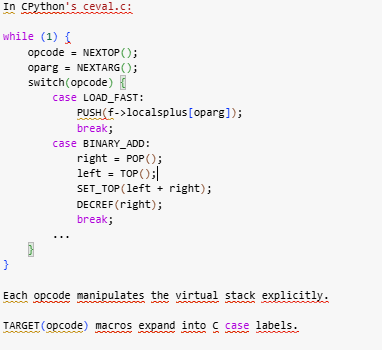


In [ ]:

# =====================================
# 6. When Disassembly Matters (and When It Doesn't)
# =====================================


- Matters:
    - When diagnosing slow paths (e.g., attribute lookup, globals access)
    - When tuning critical loops (e.g., choosing generator vs list comp)
    - When reverse engineering code behavior without source

- Doesn't Matter:
    - For general readability or maintainability — prefer clean Python code first.
    - For minor performance differences outside hot loops.


In [1]:
import dis

# --- Slower version: Repeated attribute lookup ---
class MyClass:
    def __init__(self):
        self.value = 42

def slow_access(obj):
    return obj.value + obj.value + obj.value

# --- Faster version: Cache attribute in local ---
def fast_access(obj):
    v = obj.value  # cached lookup
    return v + v + v

# Disassemble both versions
print("Disassembly of slow_access:")
dis.dis(slow_access)

print("\nDisassembly of fast_access:")
dis.dis(fast_access)

# --------------------------------------------
# EXPLANATION:
#
# In slow_access:
#   - LOAD_ATTR appears 3 times (one for each obj.value access)
#   - Each LOAD_ATTR does a dynamic attribute lookup at runtime
#     which checks instance dict, class dict, and descriptor logic.
#
# In fast_access:
#   - Only 1 LOAD_ATTR (obj.value)
#   - The result is stored in a local variable (v)
#   - Later additions just use LOAD_FAST on v (cheap local access)
#
# ⚡ Caching attributes to locals avoids repeated resolution and
#    improves performance in tight loops or performance-critical code.
# --------------------------------------------


Disassembly of slow_access:
  8           0 RESUME                   0

  9           2 LOAD_FAST                0 (obj)
              4 LOAD_ATTR                0 (value)
             14 LOAD_FAST                0 (obj)
             16 LOAD_ATTR                0 (value)
             26 BINARY_OP                0 (+)
             30 LOAD_FAST                0 (obj)
             32 LOAD_ATTR                0 (value)
             42 BINARY_OP                0 (+)
             46 RETURN_VALUE

Disassembly of fast_access:
 12           0 RESUME                   0

 13           2 LOAD_FAST                0 (obj)
              4 LOAD_ATTR                0 (value)
             14 STORE_FAST               1 (v)

 14          16 LOAD_FAST                1 (v)
             18 LOAD_FAST                1 (v)
             20 BINARY_OP                0 (+)
             24 LOAD_FAST                1 (v)
             26 BINARY_OP                0 (+)
             30 RETURN_VALUE



# ===========================
# END OF TOPIC 1
# ===========================

